In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import deepxde as dde
from deepxde.backend import tf
import seaborn as sns

%matplotlib inline

sns.set_context("talk")
dde.config.set_default_float("float64")
dde.config.set_random_seed(0)

x_max = 1e-3
y_max = 0.23e-3
t_max = 0.001

geo = dde.geometry.Hypercube((0.0, 0.0), (x_max, y_max))
time = dde.geometry.TimeDomain(0, t_max)
domain = dde.geometry.GeometryXTime(geo, time)

A = 0.09
D = 140e-6
R = D/2
P = 250
v = 200e-3
T_n = 301.3
T_h = 1500

def pde_system(X, output):
    
    T = output
    
    dT_dx = dde.grad.jacobian(T, X, j = 0)
    dT_dy = dde.grad.jacobian(T, X, j = 1)
    dT_dt = dde.grad.jacobian(T, X, j = 2)
    
    k = tf.cast(11.82+1.06e-2*T, 'float64')
    c = tf.cast(330.9+0.563*T-4.015e-4*T**2+9.465e-8*T**3, 'float64')
    rho = tf.cast(7800.0*T**0, 'float64')
    
    k_eff = k
    rho_eff = rho
    
    diff_T = dde.grad.jacobian(k_eff*dT_dx, X, j = 0) + dde.grad.jacobian(k_eff*dT_dy, X, j=1)
    
    f_T = (rho_eff*c)*dT_dt - diff_T
        
    return f_T

ic = dde.icbc.IC(domain, lambda on_initial: T_n, lambda x, on_initial: on_initial and not np.isclose(x[1], y_max, atol=y_max/20))
top = dde.icbc.DirichletBC(domain, lambda X : T_h, lambda x, on_boundary: on_boundary and np.isclose(x[1], y_max, atol=y_max/20))
sides = dde.icbc.DirichletBC(domain, lambda X : T_n, lambda x, on_boundary: on_boundary and not np.isclose(x[1], y_max, atol=y_max/20))

geo_bound = dde.geometry.geometry_1d.Interval(0, x_max)#.Hypercube((0), (x_max))
domain_bound = dde.geometry.GeometryXTime(geo_bound, time)
x_bound, t_bound = domain_bound.random_points(1000, random='Hammersley').T

input_bound = np.vstack((x_bound, y_max*np.ones(len(x_bound)), t_bound)).T
input_domain = domain.random_points(1000, random='Hammersley')

input_data = np.vstack((input_bound, input_domain))

def feature_transform(X):
    return tf.concat(
        [(X[:, 0:1]/x_max - 0.5)*2, 
            (X[:, 1:2]/y_max - 0.5)*2,
            (X[:, 2:3]/t_max - 0.5)*2], axis=1)

def modify_output(X, Y):
    x, y, t = X[:, 0:1], X[:, 1:2], X[:, 2:3]
    Temperature = Y
        #T_new = 20.0 + T_0 + Temperature*4000e22*x*y*(x-x_max)*(y-y_max)*t*z
    T_new = T_n + Temperature*5e16*x*y*(x-x_max)*t
    return tf.concat(T_new, axis = 1)

end_data = np.genfromtxt('heat_conduction/dat.csv', delimiter = ',',skip_header = True)
x, y, z, T = end_data[:, 0], end_data[:, 1], end_data[:, 2], end_data[:, 3]
xi = np.linspace(x.min(), x.max(), 100)
yi = np.linspace(y.min(), y.max(), 100)
Ti = griddata((x, y), T, (xi[None,:], yi[:,None]), method='cubic')
X = np.vstack((x, y, np.ones(len(x))*t_max)).T

Using backend: tensorflow.compat.v1

2023-03-21 18:00:56.589035: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


Instructions for updating:
non-resource variables are not supported in the long term


2023-03-21 18:01:48.021920: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-03-21 18:01:48.025131: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2023-03-21 18:01:48.121117: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:28:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2023-03-21 18:01:48.121164: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-03-21 18:01:49.393544: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-03-21 18:01:49.393680: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.

Enable just-in-time compilation with XLA.





Set the default float type to float64


Compiling model...
Building feed-forward neural network...


/home/sc.uni-leipzig.de/nl220wxeo/.conda/envs/dde/lib/python3.9/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/home/sc.uni-leipzig.de/nl220wxeo/.conda/envs/dde/lib/python3.9/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1719: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


'build' took 0.302746 s



2023-03-21 18:02:08.731858: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-21 18:02:08.732300: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-03-21 18:02:08.757248: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:28:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2023-03-21 18:02:08.757350: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-03-21 18:02:08.757400: I tensorflow/stream_executor/platform

'compile' took 9.849463 s

Initializing variables...


2023-03-21 18:02:18.395342: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:196] None of the MLIR optimization passes are enabled (registered 0 passes)
2023-03-21 18:02:18.560009: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 1999885000 Hz


Training model...



2023-03-21 18:02:19.394696: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x15351800add0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-03-21 18:02:19.394740: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2080 Ti, Compute Capability 7.5
2023-03-21 18:02:20.077535: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-03-21 18:02:26.247405: I tensorflow/compiler/jit/xla_compilation_cache.cc:333] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Step      Train loss              Test loss               Test metric
0         [6.11e+24, 2.62e+06]    [1.13e+24, 2.62e+06]    []  

Best model at step 0:
  train loss: 6.11e+24
  test loss: 1.13e+24
  test metric: []

'train' took 11.466604 s

Compiling model...
'compile' took 5.464821 s

Initializing variables...
Training model...

Step      Train loss              Test loss               Test metric
0         [1.06e+24, 1.46e+06]    [2.77e+23, 1.46e+06]    []  
100       [9.18e+18, 1.44e+06]                                
200       [8.50e+17, 1.44e+06]                                
300       [2.89e+17, 1.44e+06]                                
400       [1.65e+17, 1.44e+06]                                
500       [1.18e+17, 1.44e+06]                                
600       [8.22e+16, 1.44e+06]                                
700       [6.52e+16, 1.44e+06]                                
800       [5.25e+16, 1.44e+06]                                
900       [4.21e+16, 1.44e

2023-03-21 18:03:29.760456: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-03-21 18:03:29.761616: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:28:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.545GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2023-03-21 18:03:29.761703: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2023-03-21 18:03:29.761768: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10
2023-03-21 18:03:29.761806: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.10
2023-03-21 18:03:29.761841: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuff

'compile' took 6.002022 s

Initializing variables...
Training model...

Step      Train loss              Test loss               Test metric
0         [1.08e+25, 9.56e+05]    [5.50e+24, 9.56e+05]    []  

Best model at step 0:
  train loss: 1.08e+25
  test loss: 5.50e+24
  test metric: []

'train' took 7.978338 s

Compiling model...
'compile' took 5.925552 s

Initializing variables...
Training model...

Step      Train loss              Test loss               Test metric
0         [3.62e+00, 8.82e-01]    [7.76e-01, 8.82e-01]    []  
100       [8.91e-02, 4.30e-01]                                
200       [2.32e-02, 3.27e-01]                                
300       [3.59e-02, 2.44e-01]                                
400       [2.48e-02, 1.80e-01]                                
500       [1.99e-02, 1.54e-01]                                
600       [1.88e-02, 1.35e-01]                                
700       [1.67e-02, 1.20e-01]                                
800       [1.61e-0

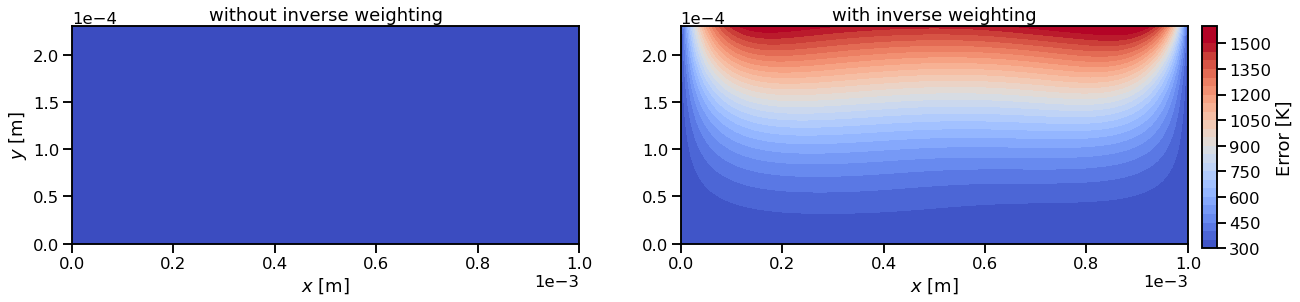

In [2]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 4))

ax1.set_xlabel('$x$ [m]')
ax1.set_ylabel('$y$ [m]')
ax2.set_xlabel('$x$ [m]')
ax1.ticklabel_format(style='sci',  scilimits=(0, 0))
ax2.ticklabel_format(style='sci',  scilimits=(0, 0))

for acti, ax, n in zip(['sin', 'sin'], [ax1, ax2], [1, 2]):
    
    data = dde.data.TimePDE(domain,
                       pde_system,
                       ic_bcs = [top],
                       num_domain = 0,
                       num_initial = 0,
                       num_boundary = 0,
                       train_distribution="Hammersley",
                       num_test = 1000,
                       anchors=input_data)
    
    net = dde.nn.FNN([3] + [20] * 6 + [1], acti, "Glorot normal")
    net.apply_feature_transform(feature_transform)
    net.apply_output_transform(modify_output)

    model = dde.Model(data, net)
    model.compile("adam", lr=1e-4)

    losshistory, train_state = model.train(iterations=0, display_every=1000)
    weights = 1/np.array(losshistory.loss_train[0])
    
    dde.optimizers.config.set_LBFGS_options(maxcor=100, maxiter=1000, maxfun = 1000, maxls=50)
    
    if n == 2:
        model.compile('L-BFGS', loss_weights=weights)
        ax.set_title('with inverse weighting')
    else: 
        model.compile('L-BFGS')
        ax.set_title('without inverse weighting')
    #model.compile('L-BFGS', loss_weights=weights)
    losshistory, train_state = model.train(display_every=100)
    """
    dde.optimizers.config.set_LBFGS_options(maxcor=100, maxiter=1000, maxls=50)
    model.compile('L-BFGS', loss_weights=weights, metrics=["l2 relative error"])
    losshistory, train_state = model.train(display_every=100)
    """
    Y = model.predict(X)

    predict = griddata((np.ravel(x), np.ravel(y)), Y[:,0], (xi[None,:], yi[:,None]), method='cubic')
    
    if n == 1:
        vmin = Y[:,0].min()
        vmax = Y[:,0].max()
    
    im = ax.contourf(xi, yi, predict, 25, cmap=plt.cm.coolwarm, vmin=T_n, vmax=T_h)
    
    if n == 2:
        cbar_ax = fig.add_axes([0.91, 0.11, 0.01, 0.77])
        fig.colorbar(im, cax=cbar_ax)
        cbar_ax.set_ylabel('Error [K]')

plt.savefig('parameter_pics/ini.pdf', bbox_inches='tight')
#plt.show()